In [1]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndimage
import xarray as xr
from metpy.units import units

ERROR 1: PROJ: proj_create_from_database: Open of /opt/miniconda3/envs/prod/share/proj failed


In [2]:
# Set year, month, day, and hour values as variables to make it
# easier to change dates for a case study

base_url = 'https://www.ncei.noaa.gov/thredds/dodsC/model-nam218'
dt = datetime(2022, 11, 27, 0)
data = xr.open_dataset('{}{dt:%Y%m}/{dt:%Y%m%d}/nam_218_{dt:%Y%m%d}_'
                       '{dt:%H}00_000.grb2'.format(base_url, dt=dt),
                       decode_times=True)

# To list all available variables for this data set,
# uncomment the following line
#print(sorted(list(data.variables)))


In [3]:
# You can print out some information to help you down the road.

#print(data)
#print(data.isobaric1)
#print(data.x)
#print(data.y)

In [4]:
# X, Y values are in units of km, need them in meters for plotting/calculations
x_tmp = (np.array(data.x[:])*units('km')).to('m')
y_tmp = (np.array(data.y[:])*units('km')).to('m')

# Make them 2D for plotting/calculations
x, y = np.meshgrid(x_tmp, y_tmp)

In [5]:
# Get the valid times from the file
vtimes = []
for t in range(data.time.size):
    vtimes.append(datetime.utcfromtimestamp(data.time[t].data.astype('O') / 1e9))
print(vtimes)

[datetime.datetime(2022, 11, 27, 0, 0)]


In [6]:
# print(data.Geopotential_height.coords)
hght_500 = data.Geopotential_height_isobaric.sel(time=vtimes[0], isobaric2=50000.)
uwnd_500 = data['u-component_of_wind_isobaric'].sel(time=vtimes[0], isobaric2=50000.)
vwnd_500 = data['v-component_of_wind_isobaric'].sel(time=vtimes[0], isobaric2=50000.)

In [7]:
print(hght_500)

<xarray.DataArray 'Geopotential_height_isobaric' (y: 428, x: 614)>
[262792 values with dtype=float32]
Coordinates:
  * x          (x) float32 -4.226e+03 -4.214e+03 ... 3.235e+03 3.247e+03
  * y          (y) float32 -832.7 -820.5 -808.3 ... 4.361e+03 4.373e+03
    reftime    datetime64[ns] ...
    time       datetime64[ns] 2022-11-27
    isobaric2  float32 5e+04
Attributes: (12/13)
    long_name:                       Geopotential height @ Isobaric surface
    units:                           gpm
    abbreviation:                    HGT
    grid_mapping:                    LambertConformal_Projection
    Grib_Variable_Id:                VAR_0-3-5_L100
    Grib2_Parameter:                 [0 3 5]
    ...                              ...
    Grib2_Parameter_Category:        Mass
    Grib2_Parameter_Name:            Geopotential height
    Grib2_Level_Type:                100
    Grib2_Level_Desc:                Isobaric surface
    Grib2_Generating_Process_Type:   Forecast
    Grib2_Stati

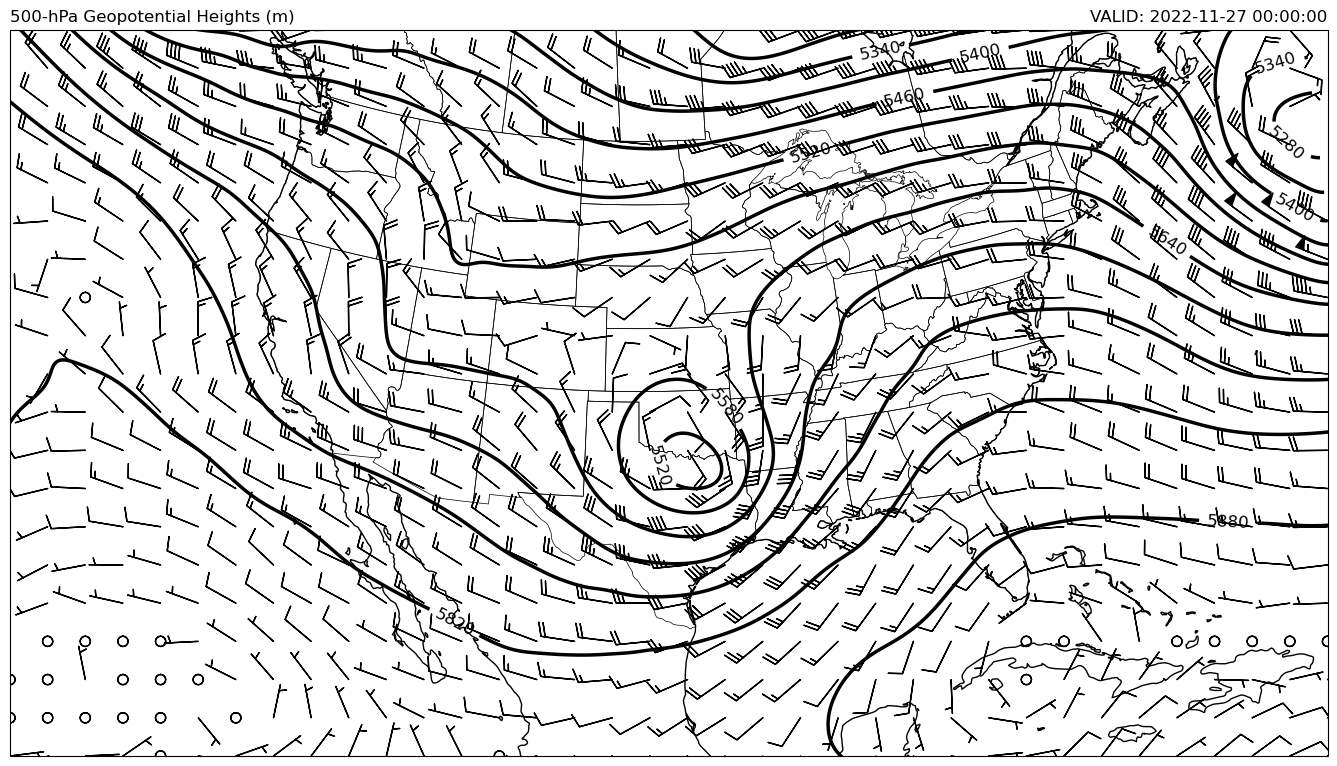

In [8]:
# Must set data projection, NAM is LCC projection
datacrs = ccrs.LambertConformal(
    central_latitude=data.LambertConformal_Projection.latitude_of_projection_origin,
    central_longitude=data.LambertConformal_Projection.longitude_of_central_meridian)

# A different LCC projection for the plot.
plotcrs = ccrs.LambertConformal(central_latitude=45., central_longitude=-100.,
                                standard_parallels=[30, 60])

fig = plt.figure(figsize=(17., 11.))
ax = plt.axes(projection=plotcrs)
ax.coastlines('50m', edgecolor='black')
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.set_extent([-130, -67, 20, 50], ccrs.PlateCarree())

clev500 = np.arange(5100, 6000, 60)
cs = ax.contour(x, y, ndimage.gaussian_filter(hght_500, sigma=5), clev500,
                colors='k', linewidths=2.5, linestyles='solid', transform=datacrs)
tl = plt.clabel(cs, fontsize=12, colors='k', inline=1, inline_spacing=8,
                fmt='%i', rightside_up=True, use_clabeltext=True)
# Here we put boxes around the clabels with a black boarder white facecolor
#for t in tl:
#    t.set_bbox({'fc': 'w'})

# Transform Vectors before plotting, then plot wind barbs.
ax.barbs(x, y, uwnd_500.data, vwnd_500.data, length=7, regrid_shape=20, transform=datacrs)

# Add some titles to make the plot readable by someone else
plt.title('500-hPa Geopotential Heights (m)', loc='left')
plt.title('VALID: {}'.format(vtimes[0]), loc='right')

plt.show()